In [1]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from glob import glob
import os

import pandas as pd
from scipy import ndimage, stats
from importlib import reload
from skimage import exposure

import utils

In [2]:
data = pd.read_csv('..' + os.sep + 'library_eY2H.csv')

src = '..' + os.sep + 'proc' + os.sep
lsrc = src + 'leyre' + os.sep
msrc = src + 'mather' + os.sep
dst = '..' + os.sep + 'proc' + os.sep

lgenes = os.listdir(lsrc)
mgenes = os.listdir(msrc)
print('Reference:\t', mgenes, '\nGenes to test:\t', lgenes, sep='')

Reference:	['p53']
Genes to test:	['LBD37']


In [3]:
lgidx, mgidx = 0,0
print('Comparing gene', lgenes[lgidx], 'with reference', mgenes[mgidx] )
gdst = dst + lsrc.split(os.sep)[-2] + os.sep + lgenes[lgidx] + os.sep
mdst = dst + msrc.split(os.sep)[-2] + os.sep + mgenes[mgidx] + os.sep
print('Will save all results in ',gdst)

Comparing gene LBD37 with reference p53
Will save all results in  ../proc/leyre/LBD37/


In [4]:
platenum = 5

ref_file = glob(msrc + mgenes[mgidx] + os.sep + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
plate_file = glob(lsrc + lgenes[lgidx] + os.sep + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
bname = '_'.join((os.path.split(os.path.splitext(plate_file)[0])[1]).split('_')[:-1])

print(ref_file, plate_file, bname, sep='\n')

../proc/mather/p53/p53_plate_05_colormatrix.csv
../proc/leyre/LBD37/20231130_plate_05_colormatrix.csv
20231130_plate_05


In [31]:
reference = np.loadtxt(ref_file, delimiter=',')
plate = np.loadtxt(plate_file, delimiter=',')
nrows, ncols = plate.shape
nonzeros = plate != 0

reference[~nonzeros] = 0
matched = exposure.match_histograms(plate, reference, channel_axis=None)

diff = reference - matched
diff[~nonzeros] = 0
vlim = np.max( np.abs( [ np.min(diff), np.max(diff) ] ) )

rhist, bins = np.histogram(reference, bins=range(1,257))
phist, _ = np.histogram(plate, bins=bins)
mhist, _ = np.histogram(matched, bins=bins)

imgsize = np.sum(nonzeros)
rcumsum = np.cumsum(rhist)/reference.size
pcumsum = np.cumsum(phist)/imgsize
mcumsum = np.cumsum(mhist)/imgsize

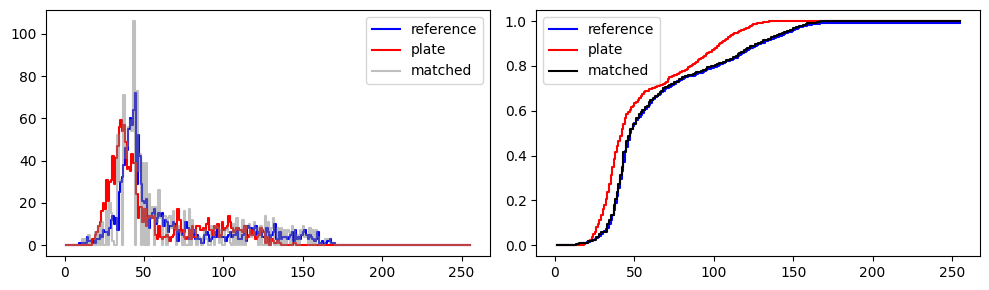

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,3), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].plot(bins[:-1], rhist, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], phist, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mhist, c='gray', ds='steps', alpha=0.5, label='matched')

i+=1
ax[i].plot(bins[:-1], rcumsum, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], pcumsum, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mcumsum, c='k', ds='steps', label='matched')

for i in range(len(ax)):
    ax[i].legend();

fig.tight_layout()

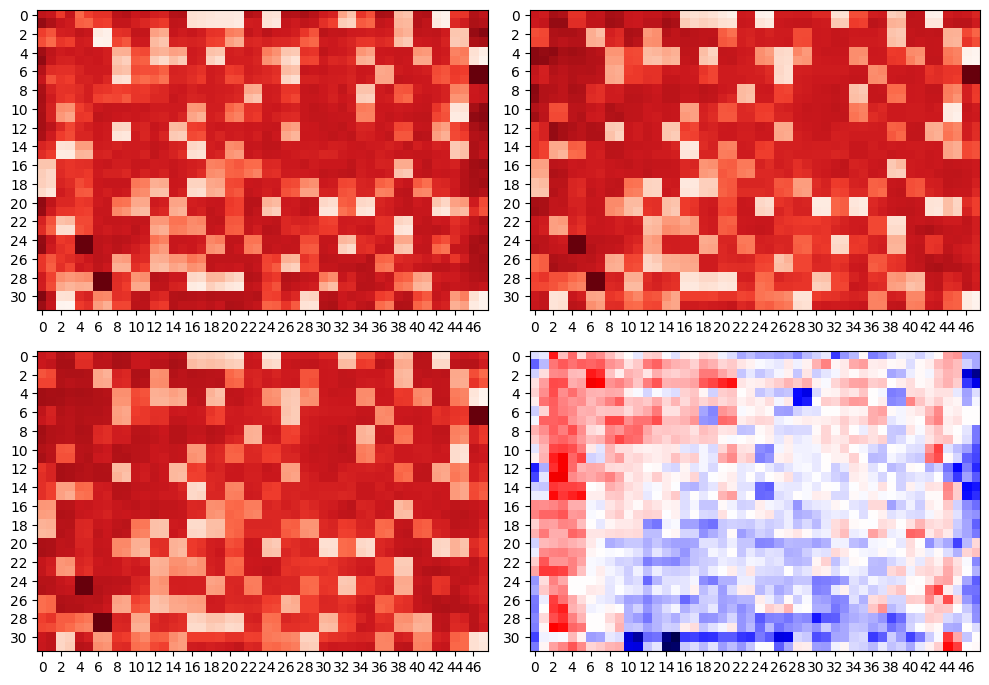

In [33]:
fig, ax = plt.subplots(2,2, figsize=(10,7), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(reference, cmap='Reds_r')
ax[1].imshow(matched, cmap='Reds_r')
ax[2].imshow(plate, cmap='Reds_r')
ax[3].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)

for i in range(len(ax)):
    ax[i].set_xticks(range(0,ncols,2), range(0,ncols,2))
    ax[i].set_yticks(range(0,nrows,2), range(0,nrows,2));
    ax[i].set_aspect('equal')

fig.tight_layout()

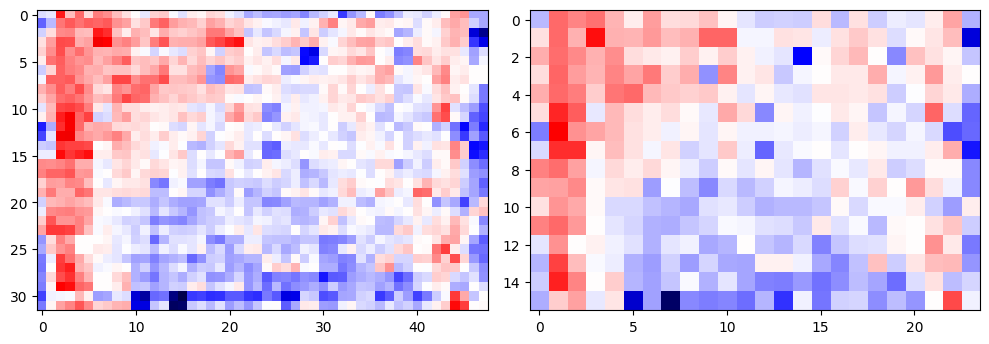

In [34]:
means = np.zeros((nrows//2, ncols//2))
for i in range(0,nrows,2):
    for j in range(0, ncols, 2):
        means[i//2,j//2] = np.mean(diff[i:i+2, j:j+2])

fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[1].imshow(means, cmap='seismic', vmin=-vlim, vmax=vlim)

fig.tight_layout()

In [35]:
dhist, dbins = np.histogram(diff[nonzeros], bins=np.linspace(-vlim-1, vlim+1, 101), density=True)
dcumsum = np.cumsum(dhist)
dcdf = (dcumsum - dcumsum[0])/(dcumsum[-1] - dcumsum[0])
xvals = dbins[:-1].copy()

mhist, _ = np.histogram(means, bins=dbins, density=True)
mcumsum = np.cumsum(mhist)
mcdf = (mcumsum - mcumsum[0])/(mcumsum[-1] - mcumsum[0])

mu, sigma = np.mean(diff), np.std(diff)
normal = 1/(np.std(diff) * np.sqrt(2 * np.pi))*np.exp( - (xvals - np.mean(diff))**2 / (2 * np.std(diff)**2))
ncumsum = np.cumsum(normal)
ncdf = (ncumsum - ncumsum[0])/(ncumsum[-1] - ncumsum[0])

b = np.std(diff)/np.sqrt(2)
laplace = np.exp(-abs(xvals)/b)/(2.*b)

lcdf = np.zeros(len(xvals))
lcdf[xvals < 0] = 0.5*np.exp((xvals[xvals < 0])/b)
lcdf[xvals >= 0] = 1-0.5*np.exp(-(xvals[xvals >= 0])/b)

print(' -- Empirical mean:\t',mu, '\n -- Empirical std:\t', sigma, '\n -- Max difference:\t', vlim, sep='')

alpha = 0.0445
print('\nalpha = {}'.format(alpha), b * np.log(2*alpha), 2*sigma, sep='\t')

alpha = 0.025
print('alpha = {}'.format(alpha), b * np.log(2*alpha), 3*sigma, sep='\t')

 -- Empirical mean:	-0.24242620014939664
 -- Empirical std:	15.278262741435464
 -- Max difference:	87.375

alpha = 0.0445	-26.134620174534525	30.556525482870928
alpha = 0.025	-32.36398376886789	45.83478822430639


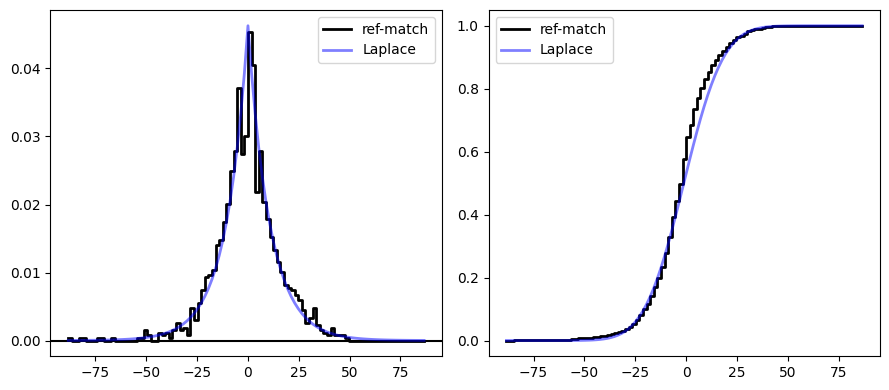

In [36]:
fig, ax = plt.subplots(1,2, figsize=(9,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].axhline(0, c='k')
ax[i].plot(xvals, dhist, c='k', lw=2, ds='steps-post', label='ref-match', zorder=1)
#ax[i].plot(xvals, mhist, c='green', lw=2, ds='steps', label='means', alpha=0.5, zorder = 2)
#ax[i].plot(xvals, normal, c='red', lw=2, label='Normal', alpha=0.5 , zorder = 3)
ax[i].plot(xvals, laplace, c='blue', lw=2, label='Laplace', alpha=0.5, zorder = 4 )

i+=1
ax[i].plot(xvals, dcdf, c='k', label='ref-match', ds='steps', lw=2, alpha=1, zorder=1)
#ax[i].plot(xvals, dcdf, c='green', label='means', ds='steps', lw=2, alpha=1, zorder=2)
#ax[i].plot(xvals, lcdf, c='r', label='Normal', ds='steps', lw=2, alpha=0.5, zorder=3)
ax[i].plot(xvals, ncdf, c='b', label='Laplace', lw=2, alpha=0.5, zorder=4)

for i in range(len(ax)):
    ax[i].legend();

fig.tight_layout()

42.26300533221948


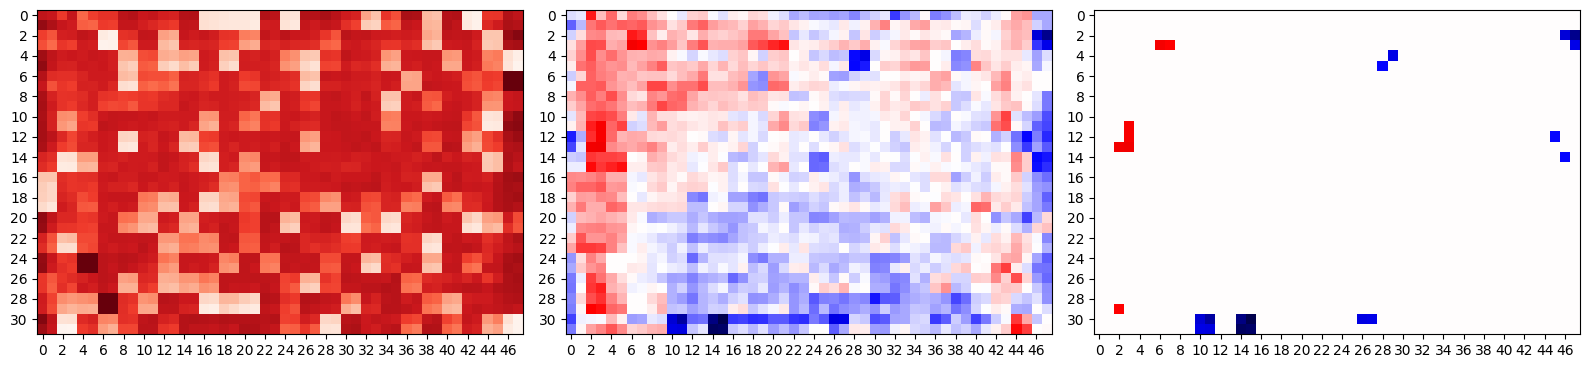

In [37]:
# FIND OUTLIERS BY SOME CRITERIA

# 1. Assume differences follow a Laplace distrubution. Outliers will be those outside the 1-alpha interval

alpha = 0.01
threshold = np.abs(b * np.log(2*alpha))
#tmask = np.abs(diff) > threshold

# 2. Outliers are those 3 stds away from the mean
#threshold = 3*np.std(diff)
print(threshold)
tmask = np.abs(diff) > threshold

# 3. Outliers will be those outside far away from the IQR, like when making boxplots
#q1,q3 = np.quantile(diff, [0.2,0.8]); iqr = q1 - q3
#tmask = (diff < q1 - 1.5*iqr) | (diff > q3 + 1.5*iqr)

fig, ax = plt.subplots(1,3, figsize=(16,5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(reference, cmap='Reds_r')
ax[1].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[2].imshow(diff*tmask, cmap='seismic', vmin=-vlim, vmax=vlim)

for i in range(len(ax)):
    ax[i].set_xticks(range(0,ncols,2), range(0,ncols,2))
    ax[i].set_yticks(range(0,nrows,2), range(0,nrows,2));
fig.tight_layout()

# Match it to gene database

In [38]:
signifscores = np.zeros((nrows//2, ncols//2), dtype=np.uint8)

for i in range(0,nrows,2):
    for j in range(0, ncols, 2):
        signifscores[i//2, j//2] = np.sum(tmask[i:i+2, j:j+2])

signifcoords = np.asarray(np.nonzero(signifscores > 2))
signifcoords

array([[ 1,  6, 15, 15],
       [23,  1,  5,  7]])

In [39]:
signifidx = np.zeros(len(signifcoords[0]), dtype=int) - 1
diffvals = np.zeros(len(signifidx))
controlcol = np.repeat(['whiteish'], len(signifidx)).astype('<U10')
platecol = np.repeat(['redish'], len(signifidx)).astype('<U10')

for i in range(len(signifidx)):
    coordinate = 'p{:02d}-r{:02d}-c{:02d}'.format(platenum, signifcoords[0,i]+1, signifcoords[1,i]+1)
    ref = data[data['Coordinate'] == coordinate]
    if len(ref) > 0:
        signifidx[i] = ref.index[0]
        diffvals[i] = diff[2*signifcoords[0,i], 2*signifcoords[1,i]]
        if diffvals[i] < 0:
            controlcol[i] = 'redish'
            platecol[i] = 'whiteish'

signifmask = signifidx > -1
signifidx

array([1583, 1681, 1901, 1903])

In [40]:
signif = data.loc[signifidx[signifmask]]
signif['IntensityDiff'] = diffvals[signifmask]
signif['ControlColor'] = controlcol[signifmask]
signif['PlateColor'] = platecol[signifmask]
signif

,Coordinate,Identifier,Family,Common_Name,IntensityDiff,ControlColor,PlateColor
1583,p05-r02-c24,AT2G30420,MYB-related,ETC2,-52.900000,redish,whiteish
1681,p05-r07-c02,AT5G51870,MADS,AGL71,36.000000,whiteish,redish
1901,p05-r16-c06,AT2G23380,SET,CLF,-53.666667,redish,whiteish
1903,p05-r16-c08,AT1G24190,Orphans,ATSIN3,-73.833333,redish,whiteish


In [41]:
filename = gdst + bname + '_significant_differences.csv'
print(filename)
signif.to_csv(filename, index=True, index_label='OriginalIndex')

../proc/leyre/LBD37/20231130_plate_05_significant_differences.csv


# Just for mental sanity

In [42]:
rsrc = '..' + os.sep + 'raw' + os.sep 
rawimg_file = os.path.split(ref_file)[0].replace(src,rsrc) + os.sep
rawimg_file = glob(rawimg_file + '*_{:02d}*'.format(platenum))[0]
rname = os.path.split(os.path.splitext(rawimg_file)[0])[1]

pltimg_file = os.path.split(plate_file)[0].replace(src,rsrc) + os.sep
pltimg_file = glob(pltimg_file + '*_{:02d}*'.format(platenum))[0]
bname = os.path.split(os.path.splitext(pltimg_file)[0])[1]

print(rawimg_file, pltimg_file, rname, bname, sep='\n')

../raw/mather/p53/p53_plate_05.jpg
../raw/leyre/LBD37/20231130_plate_05.JPG
p53_plate_05
20231130_plate_05


In [43]:
rawimg = utils.load_image(rawimg_file, check_rotation=False)

filename = mdst + rname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
rawimg = rawimg[plateslice]
filename = mdst + rname + '_centers.npy'
rawcoords = np.load(filename, allow_pickle=True)

pltimg = utils.load_image(pltimg_file, check_rotation=True, color_check=1)

filename = gdst + bname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
pltimg = pltimg[plateslice]
filename = gdst + bname + '_centers.npy'
pltcoords = np.load(filename, allow_pickle=True)

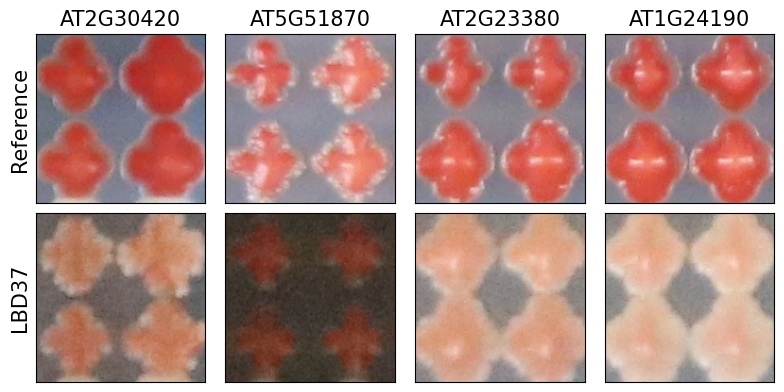

In [45]:
fs = 15
R = 80
figR = 2
fig, ax = plt.subplots(2,len(signif), figsize=(len(signif)*figR, 2*figR), sharex=True, sharey=True)
ax = ax.reshape(2, len(signif))

for i in range(len(signif)):
    j = 0
    row, col = [int(foo[1:])-1 for foo in signif.iloc[i,0].split('-')[1:] ]
    
    ax[0,i].set_title(signif.iloc[i,1], fontsize=fs)
    for (cc,img) in zip([rawcoords, pltcoords],[rawimg,pltimg]):
        dots = cc[2*row : 2*row + 2, 2*col : 2*col + 2]
        center = np.mean(np.mean(dots, axis = 0), axis = 0).astype(int)
        rss = np.s_[center[1] - R : center[1] + R, center[0] - R : center[0] + R]
        ax[j,i].imshow(img[rss], vmin=0, origin='upper'); j+=1
ax[0,0].set_ylabel('Reference', fontsize=fs)
ax[1,0].set_ylabel(lgenes[lgidx], fontsize=fs)
for a in ax.ravel():
    a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout();
#plt.savefig('foo.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [158]:
diagdst = '..' + os.sep + 

'AT5G09790'

In [75]:
wilcoxs = np.zeros((nrows//2, ncols//2))
wilcoxp = np.zeros((nrows//2, ncols//2))

for i in range(0,nrows,2):
    for j in range(0, ncols, 2):
        foo = stats.wilcoxon(diff[i:i+2, j:j+2].ravel(), method='auto', zero_method='wilcox', alternative='two-sided')
        wilcoxs[i//2, j//2] = foo.statistic
        wilcoxp[i//2, j//2] = foo.pvalue